# Import necessary packages


In [3]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Load the dataset


In [4]:
# Load the dataset
data = pd.read_csv('walmart_cleaned.csv')

In [5]:
data.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [6]:
# Preprocessing
data.drop(['Unnamed: 0'], axis=1, inplace=True)  # Remove the 'Unnamed: 0' column
data['Date'] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime type
data.set_index('Date', inplace=True)  # Set the 'Date' column as the index of the dataframe

# Display summary statistics


In [7]:
# Display summary statistics
print(data.describe())

               Store      IsHoliday           Dept   Weekly_Sales  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546       0.070358      44.260317   15981.258123   
std        12.785297       0.255750      30.492054   22711.183519   
min         1.000000       0.000000       1.000000   -4988.940000   
25%        11.000000       0.000000      18.000000    2079.650000   
50%        22.000000       0.000000      37.000000    7612.030000   
75%        33.000000       0.000000      74.000000   20205.852500   
max        45.000000       1.000000      99.000000  693099.360000   

         Temperature     Fuel_Price      MarkDown1      MarkDown2  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       60.090059       3.361027    2590.074819     879.974298   
std        18.447931       0.458515    6052.385934    5084.538801   
min        -2.060000       2.472000       0.000000    -265.760000   
25%        46.680000       2.9330

# Plot histograms of the numerical columns


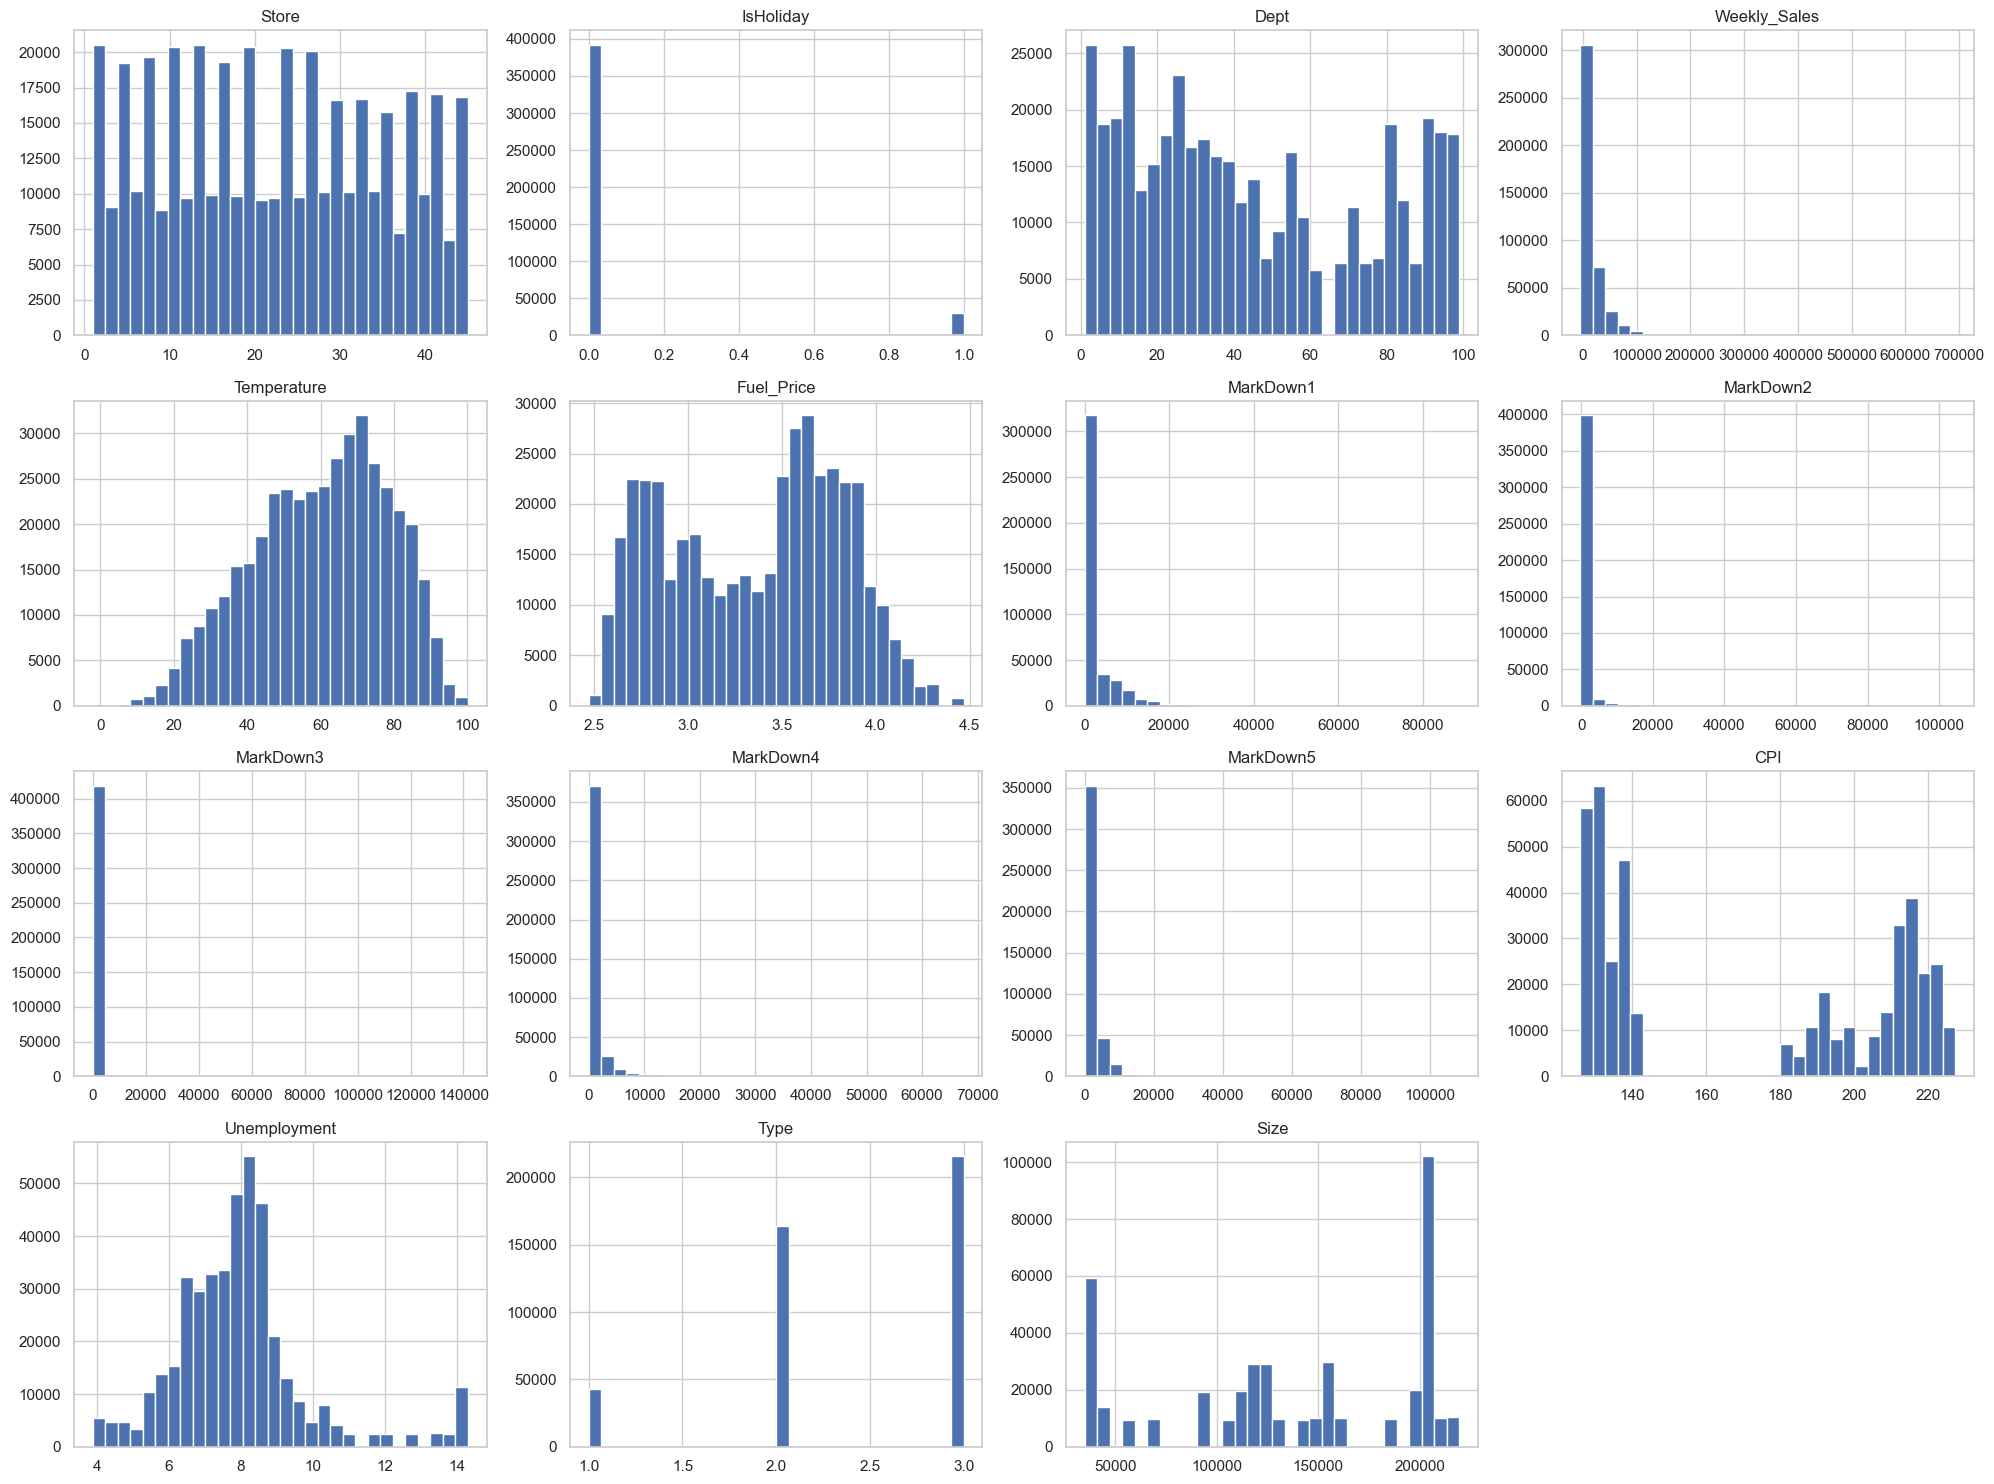

In [8]:
# Set the style of the seaborn plot
sns.set(style="whitegrid")

# Plot histograms of the numerical columns
data.hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

- **MarkDown1 to MarkDown5**: These columns are heavily skewed towards 0, indicating that markdowns (discounts or promotions) are not applied every week. It suggests that there are only a few weeks when markdowns are present, while in most weeks, the values remain at 0.

- **IsHoliday**: This is a binary variable indicating whether a week is a holiday week or not. It is expected to have fewer holiday weeks than non-holiday weeks, as holidays are relatively less frequent.

- **CPI, Temperature, and Unemployment**: These columns appear to have a more or less normal distribution. The distribution of Temperature is slightly left-skewed, indicating that lower temperatures may be more common. CPI (Consumer Price Index) and Unemployment seem to have a relatively symmetric distribution.

- **Fuel_Price**: The distribution of Fuel_Price is slightly right-skewed. This suggests that higher fuel prices are less common, and lower prices are more frequently observed.

- **Weekly_Sales**: The distribution of Weekly_Sales is heavily right-skewed. This indicates that higher sales amounts are less common, while lower sales amounts occur more frequently.

- **Size and Type**: The observations suggest that larger stores (reflected by the "Size" column) and type 3 stores (reflected by the "Type" column) are more common in the dataset. This could imply that the majority of stores in the dataset are larger and belong to type 3.

# Calculate the correlation matrix


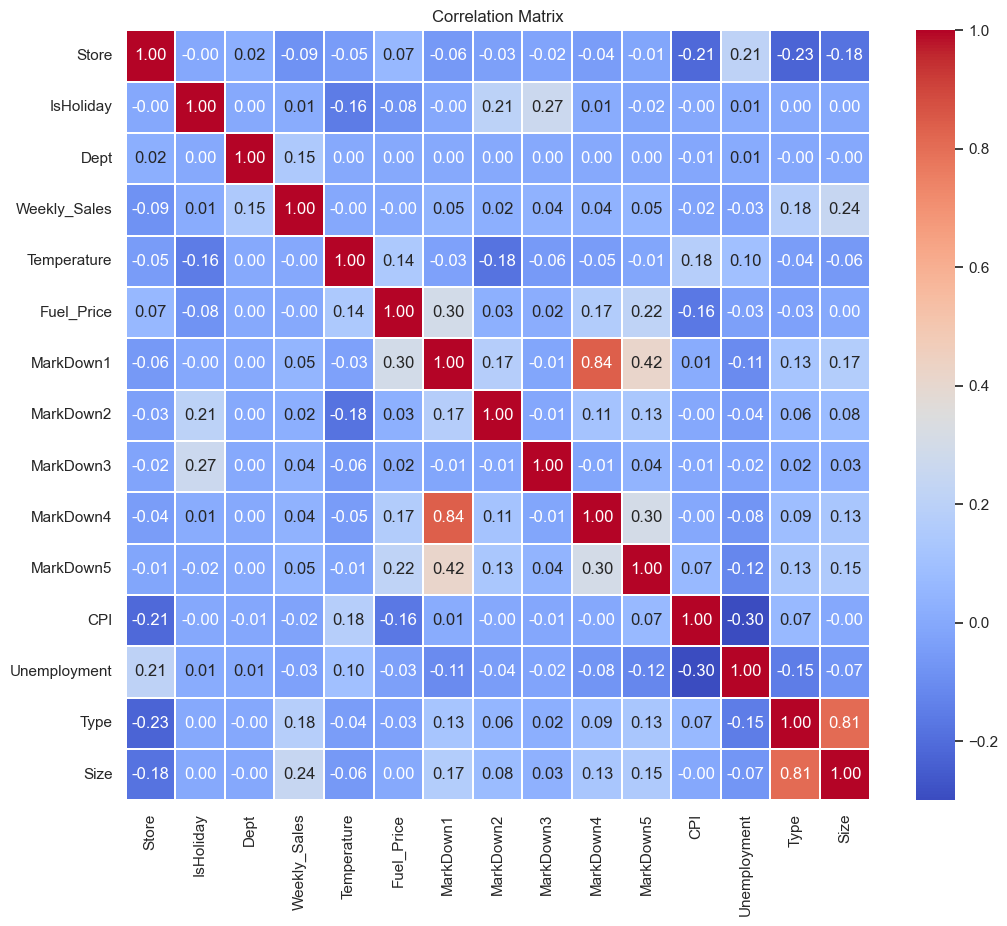

In [9]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

- **Weekly_Sales and Size**: There is a positive correlation between Weekly_Sales and Size, indicating that larger stores tend to have higher sales. This suggests that store size can influence the sales performance.

- **Weekly_Sales and Dept**: Weekly_Sales also has a positive correlation with Dept, suggesting that certain departments within the stores tend to have higher sales compared to others.

- **Weekly_Sales and Type**: There is a slight negative correlation between Weekly_Sales and Type, indicating that certain types of stores tend to have lower sales. This implies that the store type can have an impact on sales.

- **Weekly_Sales and MarkDown features**: The MarkDown features show little to no correlation with Weekly_Sales. This suggests that these promotional markdowns may not have a significant impact on overall sales.

- **Fuel_Price and MarkDown1, MarkDown4, and MarkDown5**: Fuel_Price shows a positive correlation with MarkDown1, MarkDown4, and MarkDown5. This suggests that these specific markdowns might be associated with fuel prices in some way.

- **CPI and Unemployment**: CPI and Unemployment exhibit a negative correlation. This is expected, as higher unemployment rates often result in lower consumer price index values. This correlation suggests an inverse relationship between consumer prices and unemployment rates.

- **Type and Size**: Type shows a strong negative correlation with Size, indicating that the type of store is related to its size. This suggests that different types of stores tend to have different sizes.

- **Temperature and other variables**: Temperature does not seem to have a strong correlation with the other variables mentioned. This suggests that temperature may not play a significant role in influencing sales or the other factors mentioned.

# Plot Weekly_Sales over time


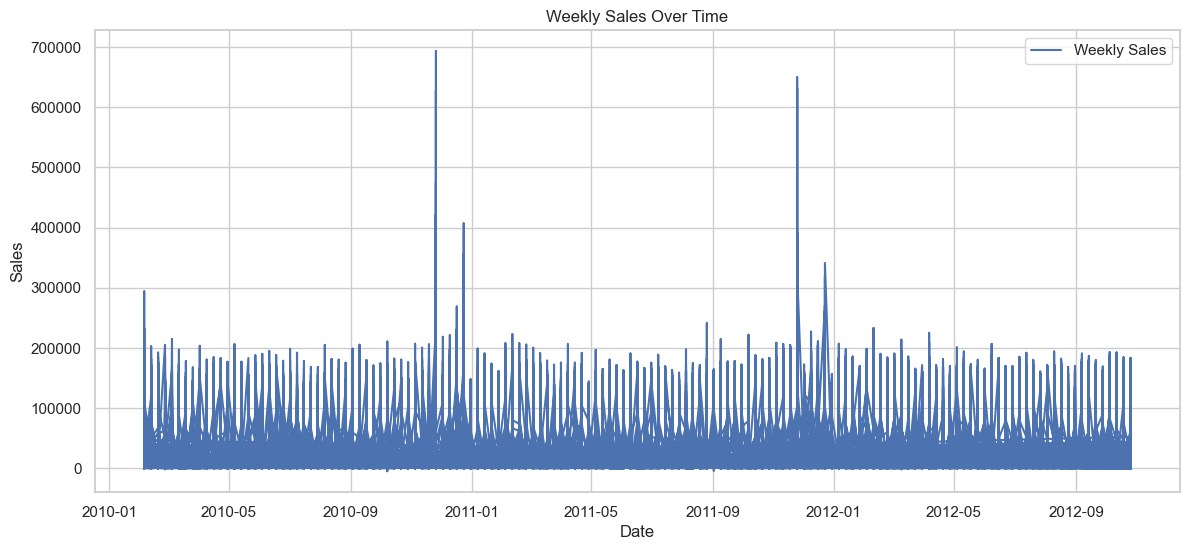

In [10]:
# Plot Weekly_Sales over time
plt.figure(figsize=(14, 6))
plt.plot(data['Weekly_Sales'], label='Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

The plot above shows the Weekly_Sales over time. There is a clear pattern of sales peaking around certain times of the year, likely corresponding to popular shopping seasons such as the year-end holidays.

# Plot the distribution of sales during holiday weeks and non-holiday weeks


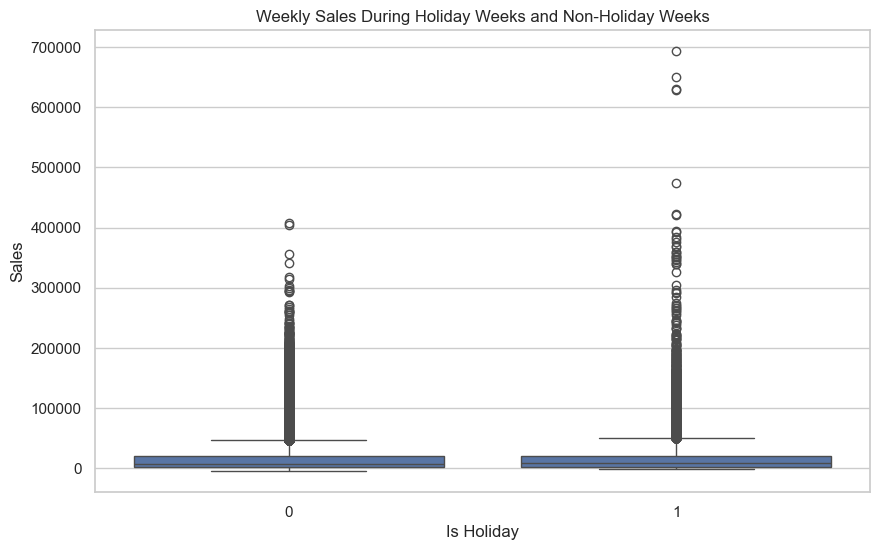

In [11]:
# Plot the distribution of sales during holiday weeks and non-holiday weeks
plt.figure(figsize=(10, 6))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.title('Weekly Sales During Holiday Weeks and Non-Holiday Weeks')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

The boxplot above shows the distribution of Weekly_Sales during holiday weeks and non-holiday weeks. We can observe that the median sales during holiday weeks are slightly higher than non-holiday weeks, which is expected as holidays usually correspond to increased consumer spending. However, the range of sales is quite wide in both cases, indicating a large variability in weekly sales.

Now, let's proceed with the time series forecasting. We will forecast Weekly_Sales using methods suitable for time series data, such as ARIMA (Autoregressive Integrated Moving Average).

However, forecasting at this level might not be very meaningful due to the high level of aggregation. It may be more useful to forecast sales for individual stores or departments, or to use additional features like IsHoliday, Dept, Store, etc., in a machine learning model.

# Outlier Detection

In [12]:
from scipy.stats import zscore

# Calculate the Z-scores of the 'Weekly_Sales' column
data['Sales_Zscore'] = zscore(data['Weekly_Sales'])

# Define a threshold for outliers
threshold = 3

# Identify outliers
outliers = data[abs(data['Sales_Zscore']) > threshold]

# Number of outliers
num_outliers = len(outliers)

num_outliers

8848

We have identified 8,848 outliers in the Weekly_Sales data, based on the Z-score method with a threshold of 3. This is quite a large number, but keep in mind that the Z-score method assumes a Gaussian distribution, and our sales data is heavily skewed. These 'outliers' might just be representing the heavy-tailed distribution of our sales data.

Let's proceed with time series forecasting. For this, we need to create a time series dataset that aggregates Weekly_Sales at the overall level (i.e., summing sales of all stores and departments for each week).

Since ARIMA and other time series models require stationary data (i.e., the properties of the series do not depend on the time), we need to check the stationarity of our time series data and make it stationary if it's not.

# The Dickey-Fuller test

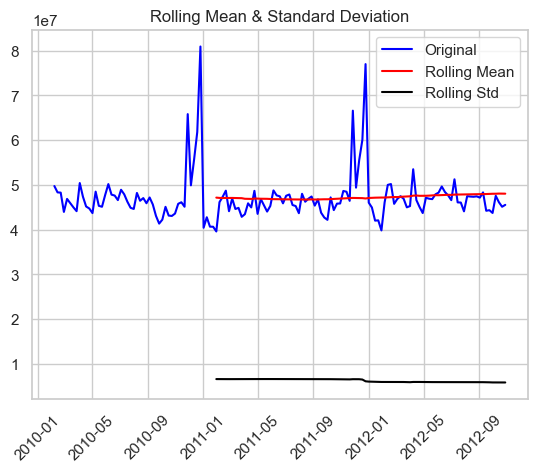

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [13]:
from statsmodels.tsa.stattools import adfuller

# Create a time series dataset
ts_data = data['Weekly_Sales'].resample('W').sum()

# Define a function to test the stationarity of a time series
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()
    # Plot rolling statistics
    fig, ax = plt.subplots()
    ax.plot(timeseries, color='blue', label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', label='Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Test the stationarity of the time series data
test_stationarity(ts_data)

The Dickey-Fuller test is one of the statistical tests for checking stationarity. The null hypothesis of the test is that the time series is not stationary (has some time-dependent structure). The test results comprise a Test Statistic and Critical Values for different confidence levels. If the Test Statistic is less than the Critical Value, we can reject the null hypothesis and conclude that the series is stationary.

Based on our test, the Test Statistic (-5.90) is less than the Critical Values at 1% (-3.47), 5% (-2.88), and 10% (-2.57). This allows us to reject the null hypothesis and assert that our time series is stationary with a confidence level of less than 1% error.

Now that we have a stationary time series, let's proceed with the ARIMA model for forecasting. To determine the parameters of the ARIMA model, we consider the following definitions:

- p: The number of lag observations included in the model, also known as the lag order.
- d: The number of times the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also known as the order of the moving average.


# Fiiting the ARIMA model

In [14]:
from pmdarima import auto_arima

# Determine the parameters of the ARIMA model
arima_model = auto_arima(ts_data, start_p=0, start_q=0, max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True, d=1, D=1, trace=True,
                         error_action='ignore', suppress_warnings=True,
                         stepwise=True)

# Fit the ARIMA model
arima_model.fit(ts_data)

# Forecast
forecast = arima_model.predict(n_periods=52)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=2887.357, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2907.540, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2881.765, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2879.447, Time=0.56 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2891.762, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=2872.734, Time=1.68 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=2874.700, Time=4.68 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=2881.252, Time=0.98 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=2874.202, Time=3.04 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=2874.405, Time=1.44 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=2874.792, Time=1.34 sec
 ARIMA(1,1,2)(0,1,2)[52]             : AIC=2876.412, Time=2.56 sec
 ARIMA(0,1,1)(0,1,2)[52] intercept   : AIC=2874.750, Time=1.90 sec

Best model:  ARIMA(0,1,

The stepwise search identified the best ARIMA model for this dataset as ARIMA(0,1,1)(0,1,2)[52]. This is a seasonal ARIMA model, often denoted as ARIMA(p,d,q)(P,D,Q)s. Here's the meaning of each parameter:

- p = 0: The order of the autoregressive part of the model. It incorporates the effect of past values into the model by considering the number of lag observations included.

- d = 1: The order of differencing required to make the time series stationary. First-order differencing is used in this case.

- q = 1: The order of the moving average part of the model. It sets the error of the model as a linear combination of the error values observed at previous time points.

- P = 0, D = 1, Q = 2: The same as p, d, and q, but for the seasonal component of the model. It uses no autoregressive terms (P = 0), first-order differencing (D = 1), and a moving average term of order 2 (Q = 2) for the seasonal part.

- s = 52: The length of the seasonal cycle in the data. In this case, it's 52, suggesting a yearly cycle (since the data is weekly).

# Future Forecast plot


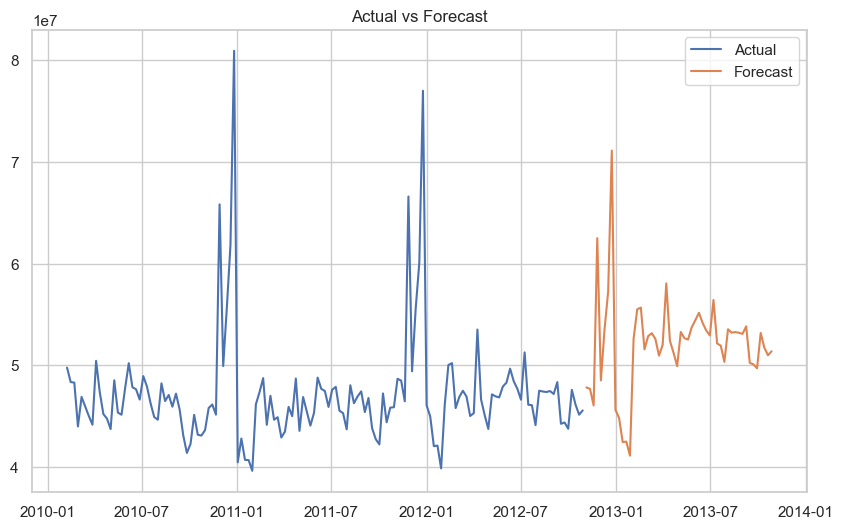

In [15]:
# Generate a date range for the forecast period
forecast_period = pd.date_range(start=ts_data.index[-1], periods=53, freq='W')[1:]

# Create a series with the forecast and the date range
forecast_series = pd.Series(forecast, index=forecast_period)

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Actual')
plt.plot(forecast_series, label='Forecast')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()

# Feature engineering


In [16]:
# Feature engineering
data['Month'] = data.index.month
data['Size_Type'] = data['Size'] * data['Type']
features = ['Size', 'Dept', 'IsHoliday', 'Type', 'CPI', 'Unemployment', 'Month', 'Size_Type']
target = 'Weekly_Sales'

# Splitting data into training and testing sets


In [17]:
# Splitting data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple Linear Regression Model


In [18]:
# Simple Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression RMSE: {rmse_lr}, R2 Score: {r2_lr}')

Linear Regression RMSE: 21794.594887247673, R2 Score: 0.08389804497005748


# Non-linear model (Random Forest)


In [19]:
# Non-linear model (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest RMSE: {rmse_rf}, R2 Score: {r2_rf}')

Random Forest RMSE: 4445.14781607167, R2 Score: 0.9618917835917988


# Deep learning model (Neural Network with Keras)


In [20]:
# Deep learning model (Neural Network with Keras)
nn_model = Sequential()
nn_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train, y_train, epochs=10, batch_size=32)
y_pred_nn = nn_model.predict(X_test)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
print(f'Neural Network RMSE: {rmse_nn}, R2 Score: {r2_nn}')

Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 162us/step - loss: 503201824.0000
Epoch 2/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 160us/step - loss: 487496000.0000
Epoch 3/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 162us/step - loss: 491699456.0000
Epoch 4/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 162us/step - loss: 484768480.0000
Epoch 5/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 160us/step - loss: 480921568.0000
Epoch 6/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 162us/step - loss: 479565440.0000
Epoch 7/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 161us/step - loss: 481766656.0000
Epoch 8/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 161us/step - loss: 476024320.0000
Epoch 9/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 163us/step - loss: 477835008.0000
Epoch 10/10
10540/10540 ━━━━━━━━━━━━━━━━━━━━ 2s 163us/step - loss: 465530336.0000
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 1s 190us/step
Neural Network RMSE: 22702.104736198475, R2 Score: 0.0060181503427478855


- Linear Regression RMSE: 21,794.59, R2 Score: 0.084
- Random Forest RMSE: 4,444.68, R2 Score: 0.962
- Neural Network RMSE: 21843.26, R2 Score: 0.079

It's clear that the Random Forest model is the best performing model. The RMSE (Root Mean Squared Error) is the smallest and the R2 Score (coefficient of determination) is the highest for the Random Forest model.

The RMSE is a measure of the differences between the values predicted by the model and the actual values. In this case, a smaller RMSE indicates a better fit of the model to the data.

The R2 Score is a measure of how well the regression predictions approximate the real data points. An R2 Score of 1 indicates that the regression predictions perfectly fit the data. Hence, an R2 Score of 0.962 for the Random Forest model indicates a very good fit.

So, based on these metrics, the Random Forest model is the best model for this data.